## Step by Step plots of what LOESS (LOcally Estimated Scatterplot Smoothing)

NOTES:
1. After this works, determine if we can save time by caching grid / stencil for regression
1. Expand to 2D and then data on globe (=> maybe convert $(\lambda, \theta)$ on unit circle to $(x, y, z=\sqrt{1-x^2-y^2})$

#### Initial Setup

Import modules, define plot size parameter, define `RMSE()` for error checking, and set `(x, y)` for plotting.

In [1]:
# Initial imports

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
try:
    # This is Cappellari's loess_1d module, except
    # I apply robustness weights twice rather than
    # have logic to determine how many times to apply
    from my_loess.loess_1d import loess_1d
except:
    from loess.loess_1d import loess_1d
from my_loess.loess import loess

In [2]:
# Place figures within document
# This is in its own cell otherwise rcParams set is ignored
# (Possibly related to https://github.com/jupyter/notebook/issues/3385)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0) # Large figures

# Also set number of plot points and seed random number generator
tot_points = 200
np.random.seed(123)

# Lastly, define RMSE function for comparing results
def RMSE(est_val, true_val):
    """ sqrt(1/n * sum of square differences)
    """
    assert est_val.size == true_val.size, "Arrays must be same size"
    N = est_val.size
    print("RMSE: {:.4f}".format(np.sqrt(np.sum((est_val - true_val)**2)/N)))

Comparing to software package from Cappellari et al. (2013) => test with same example as found in loess_1d

In [3]:
# use same x values as loess_1d example
x = np.sort(np.random.uniform(-1, 1, tot_points))

# use same y values as loess_1d example
# (1) start with y = sin(3x)
y_true = np.sin(3*x)
# (2) add some small random noise (sigma = 0.4)
y_eval = np.random.normal(y_true, 0.4)
# (3) to 10% of the points, add larger random noise (sigma = 2)
bad_inds = np.random.randint(0, tot_points, int(tot_points*0.1))
y_eval[bad_inds] += np.random.normal(0, 2, bad_inds.size)

# initialize class
test = loess(x, y_eval)

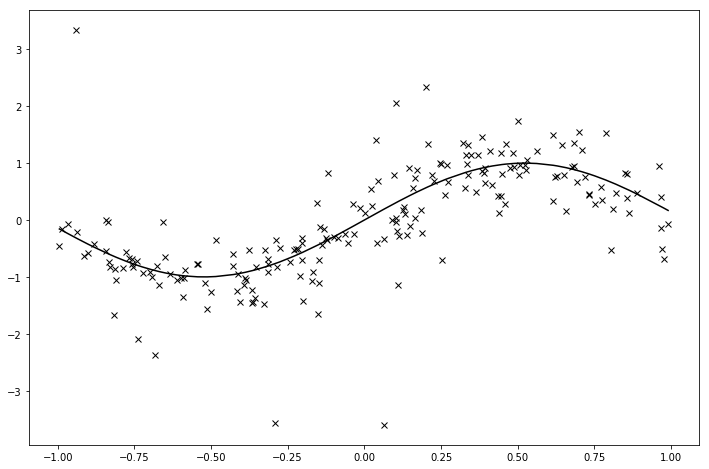

In [4]:
plt.plot(test.x, y_true, 'k')
plt.plot(test.x, test.y, 'kx')

#### 1. Polynomial fit

Using notation from Cleveland (1979), the goal is to determine $\{\hat{y}_i\}$, estimates of $\{y_i\}$ from points $(x, y) \in \{(x_i, y_i)\}$

For this step, we fit a polynomial of degree $d$ to the $n$ points $(x_j, y_j)$ where $x_j$ represents the $n$ closest points to $x_i$.
Use weighted regression with weight function $W(x) = (1 - (|x_i - x_j|/h_i)^3)^3$, where $h_i = \max(|x_i - x_j|)$ among the $n$ points

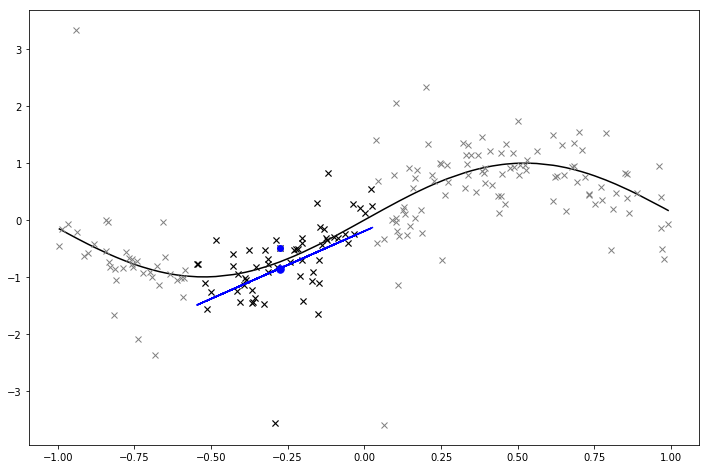

In [5]:
# Choose n and d
n = 60 # 30% of tot_points
d = 1  # We will use linear regression

# Pick a point ~1/3 of the way into the domain
i = tot_points//3

betas, xj, yj = test.poly_fit_at_i(i, n, d)

yhati = 0
yhat = np.zeros(xj.shape)
for p, beta in enumerate(betas):
    yhati += beta * (x[i]**p)
    yhat  += beta * (xj**p)

# True distribution is solid black
plt.plot(x, y_true, 'k')
# Sampled data is gray x
plt.plot(x, y_eval, 'x', color="grey")
# Sampled data used for local regression is black x
plt.plot(xj, yj, 'kx')
# Node i in red dot
plt.plot(x[i], y_eval[i], 'bo')
# Local polynomial fit in solid blue
plt.plot(xj, yhat, 'b')
# Estimated value at x[i] is big blue *
plt.plot(x[i], yhati, 'bo', markersize=7.5)

#### 2. Apply Robustness Weights (locally)

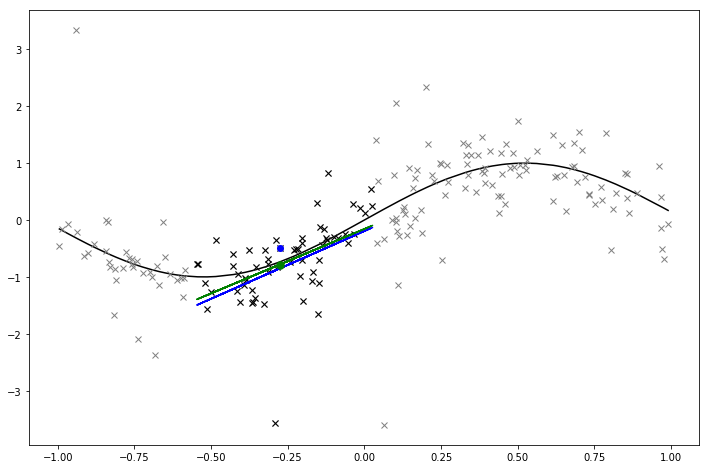

In [6]:
# Choose n and d
n = 60 # 30% of tot_points
d = 1  # We will use linear regression

# Pick a point ~1/3 of the way into the domain
i = tot_points//3

betas, xj, yj = test.poly_fit_at_i(i, n, d, t=2)

yhati = 0
yhat2 = np.zeros(xj.shape)
for p, beta in enumerate(betas):
    yhati += beta * (x[i]**p)
    yhat2 += beta * (xj**p)

# True distribution is solid black
plt.plot(x, y_true, 'k')
# Sampled data is gray x
plt.plot(x, y_eval, 'x', color="grey")
# Sampled data used for local regression is black x
plt.plot(xj, yj, 'kx')
# Node i in red dot
plt.plot(x[i], y_eval[i], 'bo')
# Local polynomial fit in solid blue
plt.plot(xj, yhat, 'b')
# Robustness adjusted polynomial fit in solid green
plt.plot(xj, yhat2, 'g')
# Newly estimated value at x[i] is big green *
plt.plot(x[i], yhati, 'go', markersize=7.5)

#### 3. Repeat this process for all nodes

In [7]:
%time yhat2 = test.poly_fit(n, d, t=2)
RMSE(yhat2, y_true)

CPU times: user 316 ms, sys: 9.08 ms, total: 326 ms
Wall time: 333 ms
RMSE: 0.0768


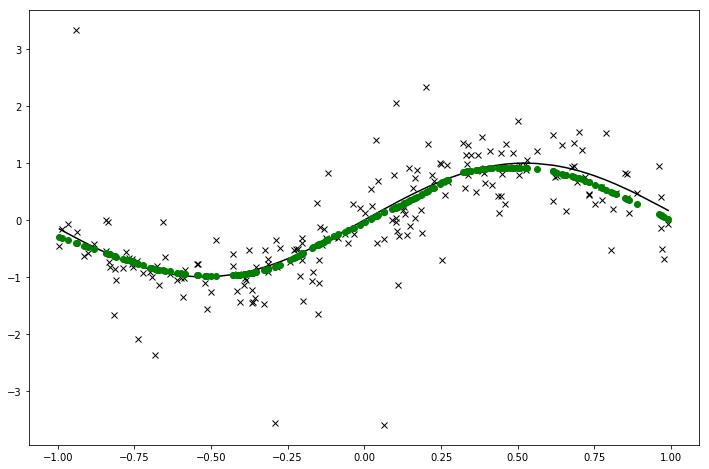

In [8]:
# True distribution is solid black
plt.plot(test.x, y_true, 'k')
# Sampled data in black x
plt.plot(test.x, test.y, 'kx')
# Robust estimated values at each x[i] is green dot
plt.plot(test.x, yhat2, 'go')

#### Compare to loess_1d package

CPU times: user 126 ms, sys: 4.81 ms, total: 130 ms
Wall time: 130 ms
RMSE: 0.0768
Largest difference between loess package and code above: 3.1086244689504383e-15


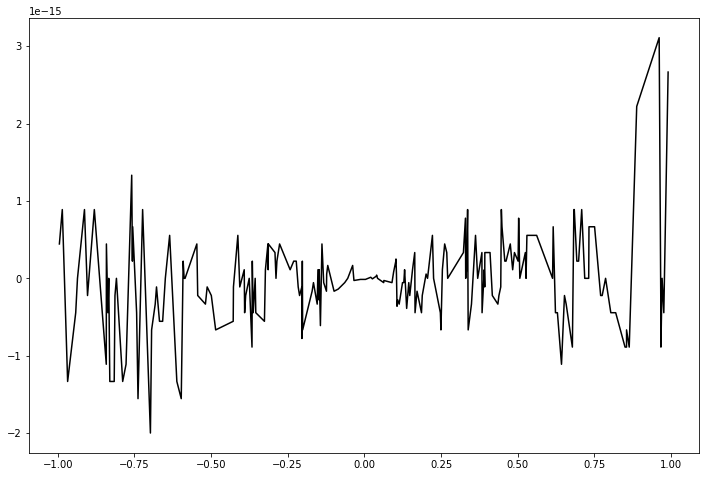

In [9]:
%time xout, yout, weigts = loess_1d(x, y_eval, frac=0.3)
RMSE(yout, y_true)

diff = yout - yhat2
plt.plot(test.x, diff, 'k')
print("Largest difference between loess package and code above: {}".format(np.max(np.abs(diff))))

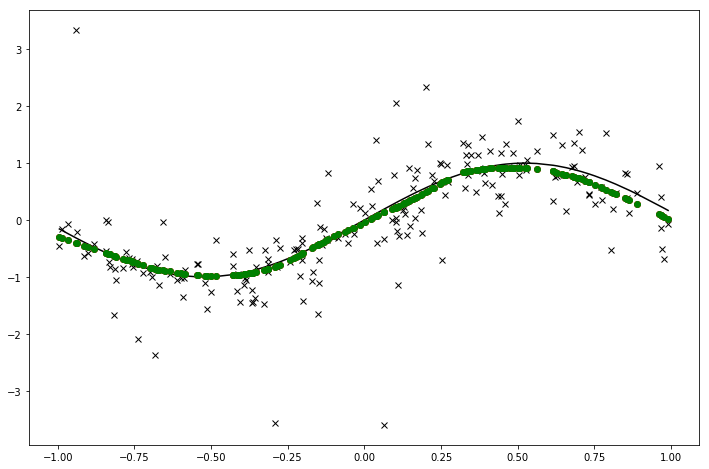

In [10]:
# True distribution is solid black
plt.plot(test.x, y_true, 'k')
# Sampled data in black x
plt.plot(test.x, test.y, 'kx')
# loess package estimated value at each x[i] is red dot
plt.plot(test.x, yout, 'ro')
# My estimated value at each x[i] is green dot
plt.plot(x, yhat2, 'go')